In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 100#'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_28_21_24_27_126485


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()

encoder.add(tf.keras.layers.InputLayer(input_shape=dims))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.1))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.3))

# Converting 3D feature to 1D feature Vektor
encoder.add(tf.keras.layers.Flatten())

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.5))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=256))
# Normalization
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(tf.keras.layers.Dense(units=64, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [23]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [24]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


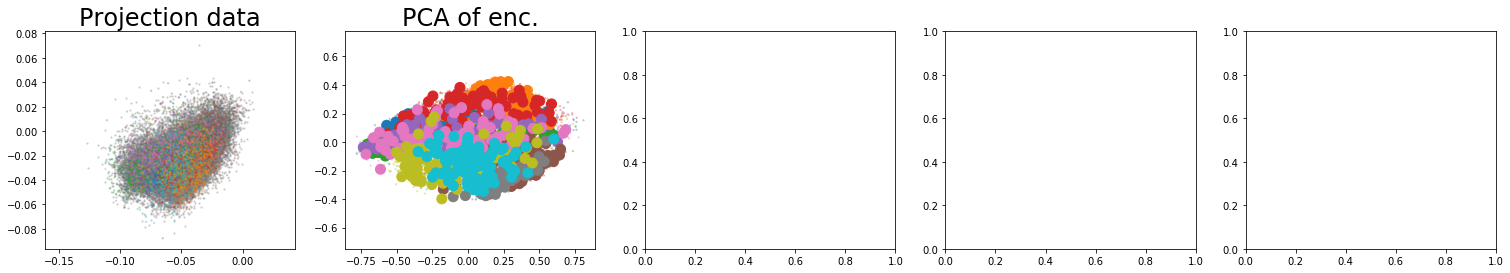

In [25]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [26]:
from tfumap.paths import MODEL_DIR

In [27]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [28]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 2500 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stopping = False
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring

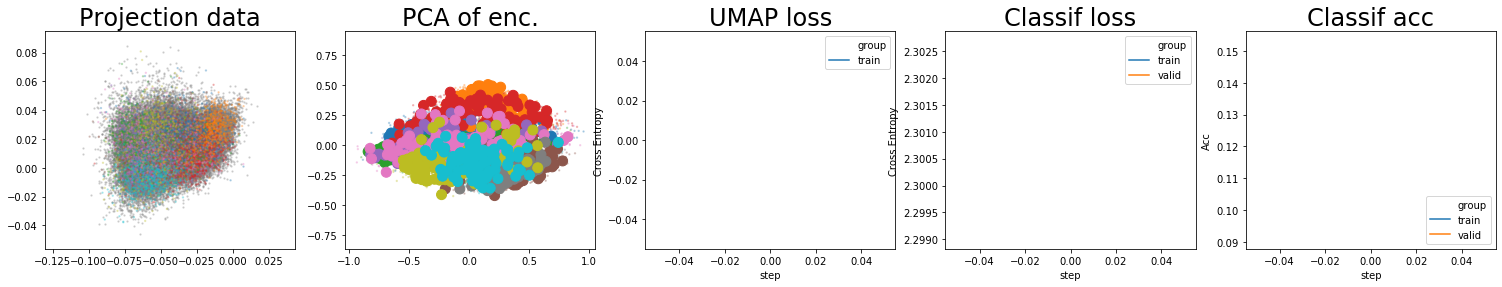

batch: 0 | train acc: 0.091 | val acc: 0.153
tf.Tensor(0.153, shape=(), dtype=float32) -0.01
saving weights


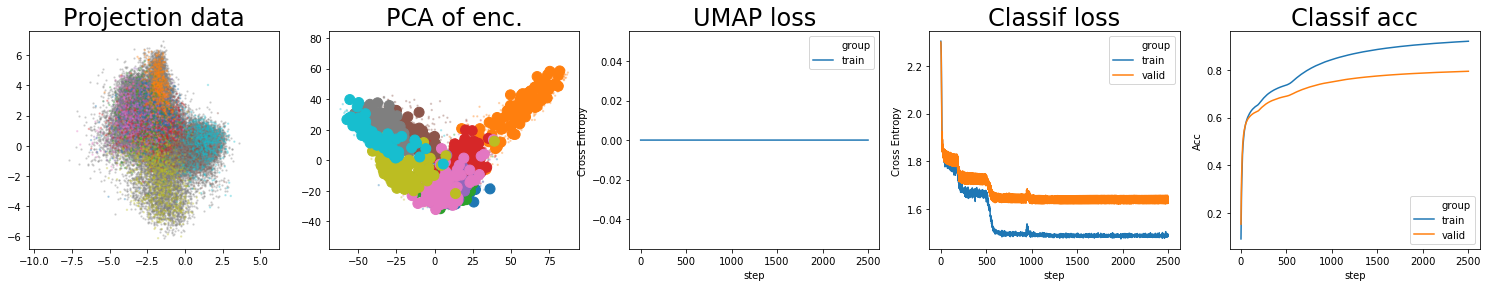

batch: 2500 | train acc: 0.9203 | val acc: 0.7944
tf.Tensor(0.7943563, shape=(), dtype=float32) 0.14299999713897704
saving weights


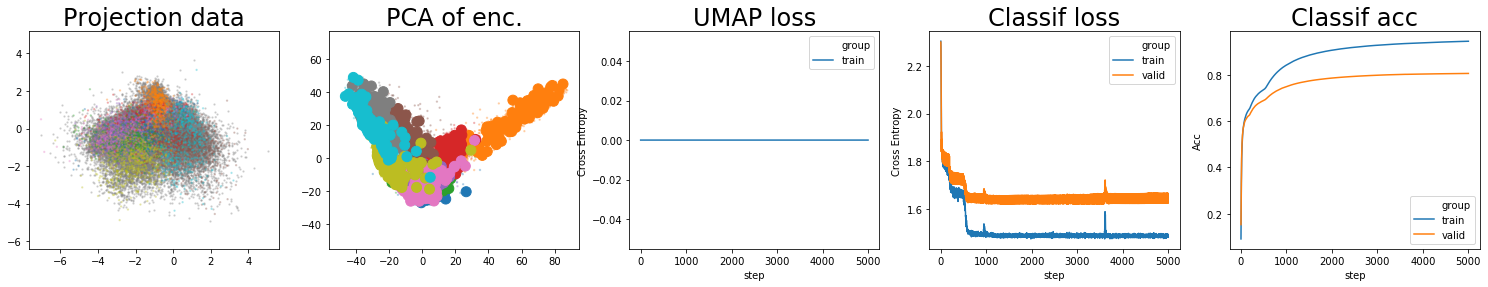

batch: 5000 | train acc: 0.9462 | val acc: 0.807
tf.Tensor(0.806964, shape=(), dtype=float32) 0.7843562865257263
saving weights


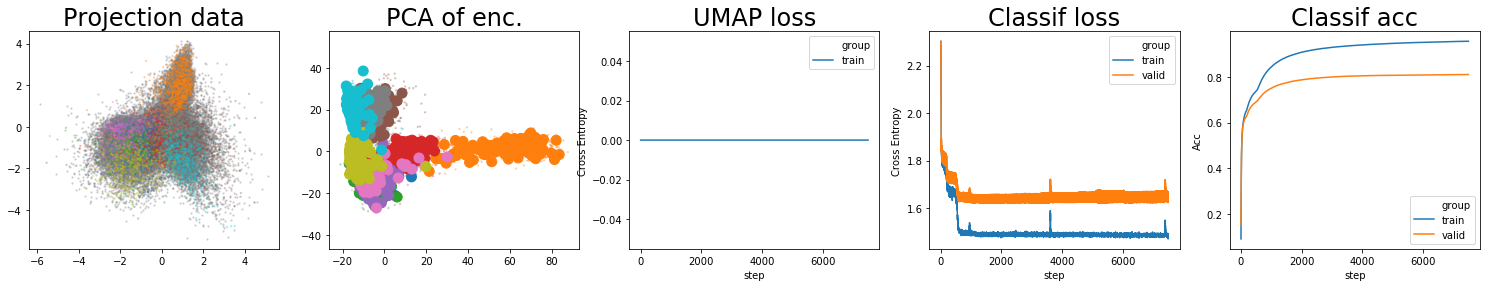

batch: 7500 | train acc: 0.9556 | val acc: 0.81
tf.Tensor(0.81004864, shape=(), dtype=float32) 0.7969639801979065
saving weights


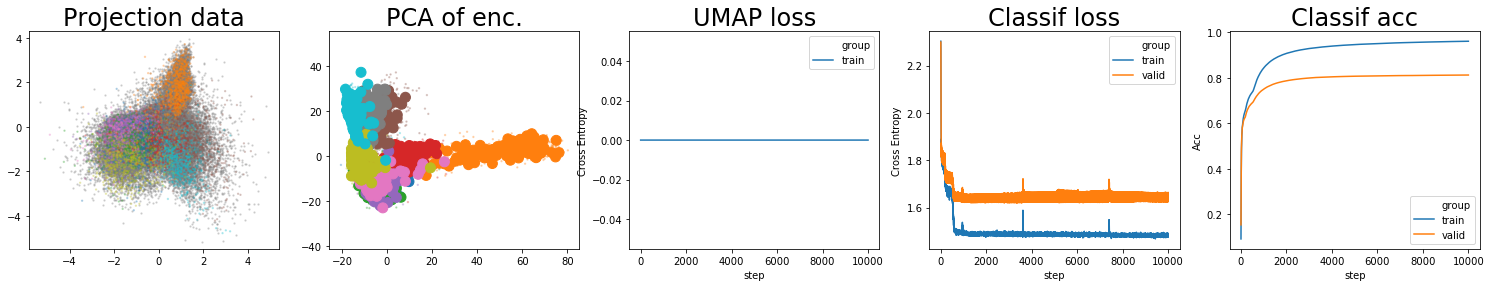

batch: 10000 | train acc: 0.9609 | val acc: 0.8123
tf.Tensor(0.81226987, shape=(), dtype=float32) 0.8000486397743225
saving weights


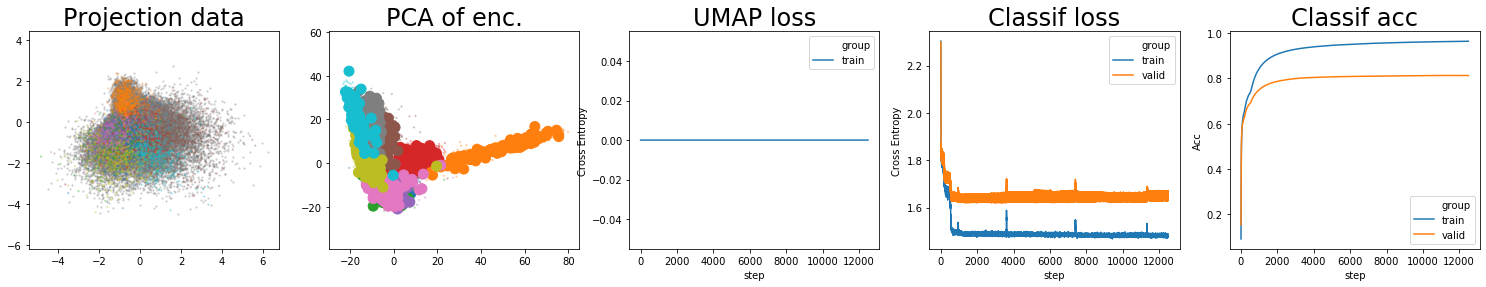

batch: 12500 | train acc: 0.9642 | val acc: 0.8128
tf.Tensor(0.8128397, shape=(), dtype=float32) 0.8022698664665222
saving weights


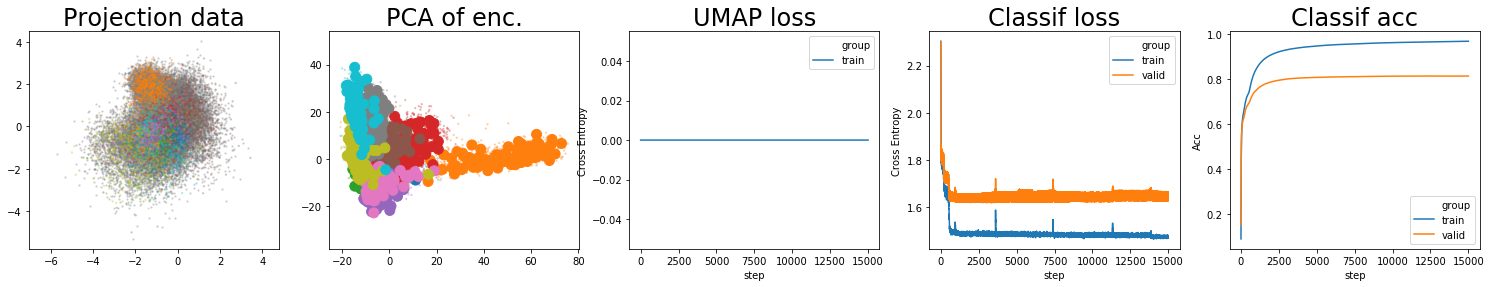

batch: 15000 | train acc: 0.9671 | val acc: 0.8128
tf.Tensor(0.8127958, shape=(), dtype=float32) 0.8028396868705749


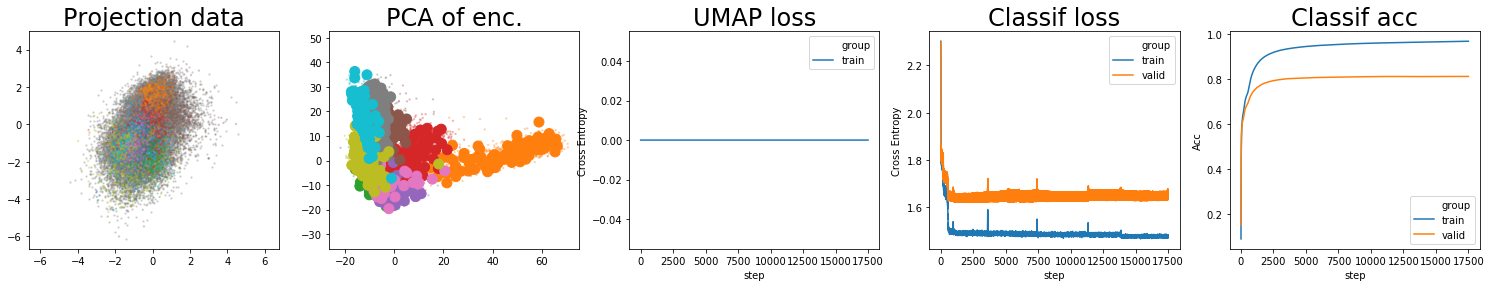

batch: 17500 | train acc: 0.9696 | val acc: 0.8132
tf.Tensor(0.8131911, shape=(), dtype=float32) 0.8028396868705749
saving weights


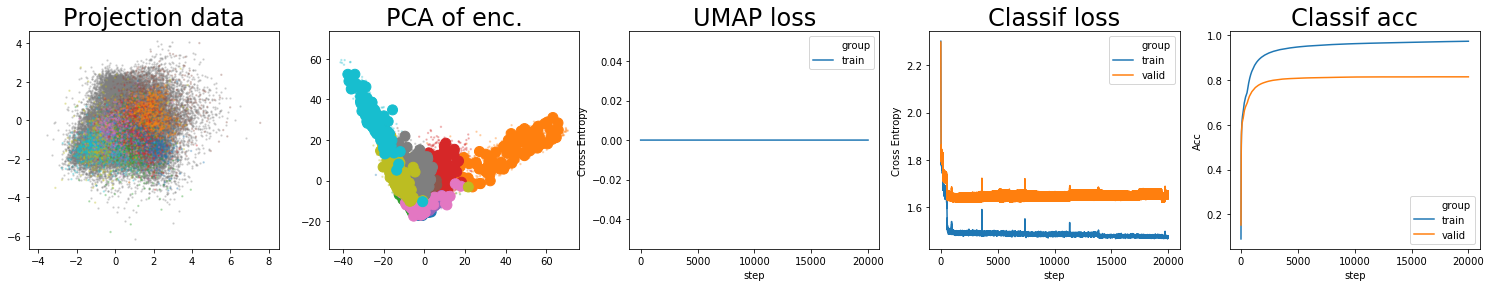

batch: 20000 | train acc: 0.9717 | val acc: 0.8131
tf.Tensor(0.8131409, shape=(), dtype=float32) 0.8031911158561706


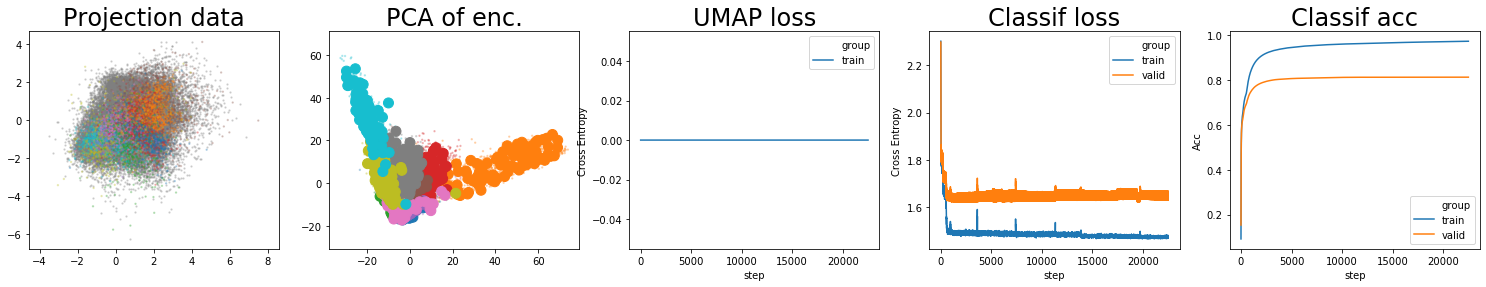

batch: 22500 | train acc: 0.9737 | val acc: 0.8132
tf.Tensor(0.81322306, shape=(), dtype=float32) 0.8031911158561706
saving weights


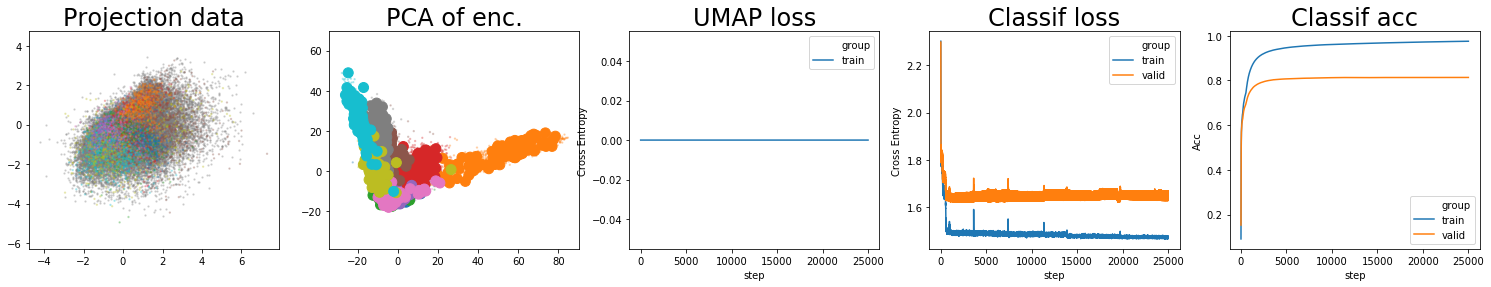

batch: 25000 | train acc: 0.9753 | val acc: 0.8133
tf.Tensor(0.8133321, shape=(), dtype=float32) 0.8032230639457703
saving weights


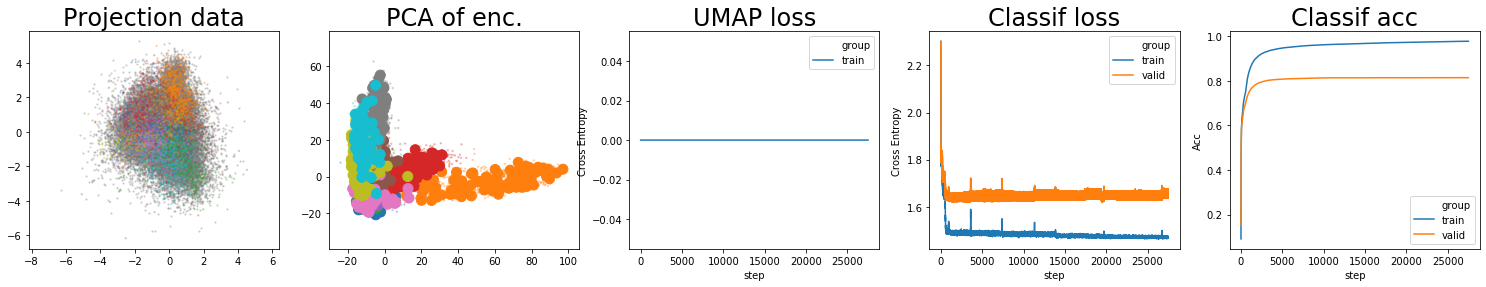

batch: 27500 | train acc: 0.9766 | val acc: 0.8132
tf.Tensor(0.8131812, shape=(), dtype=float32) 0.8033320808410644


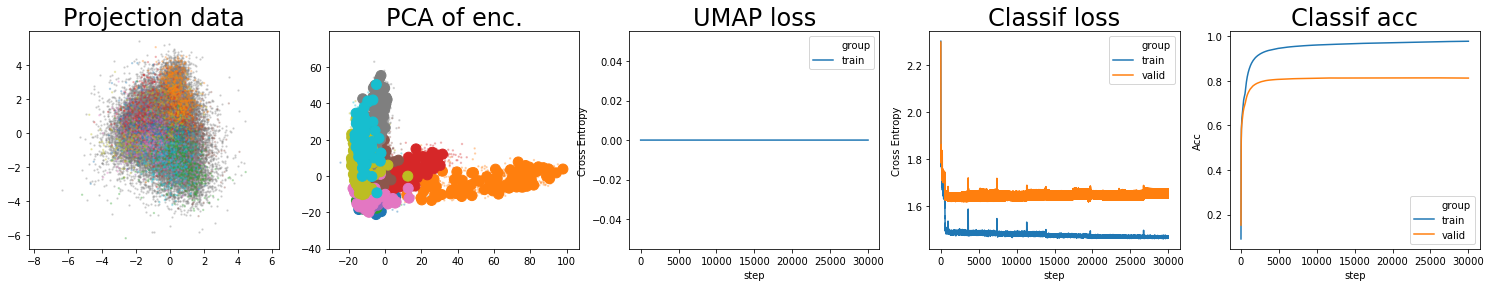

batch: 30000 | train acc: 0.9778 | val acc: 0.8125
tf.Tensor(0.8125452, shape=(), dtype=float32) 0.8033320808410644


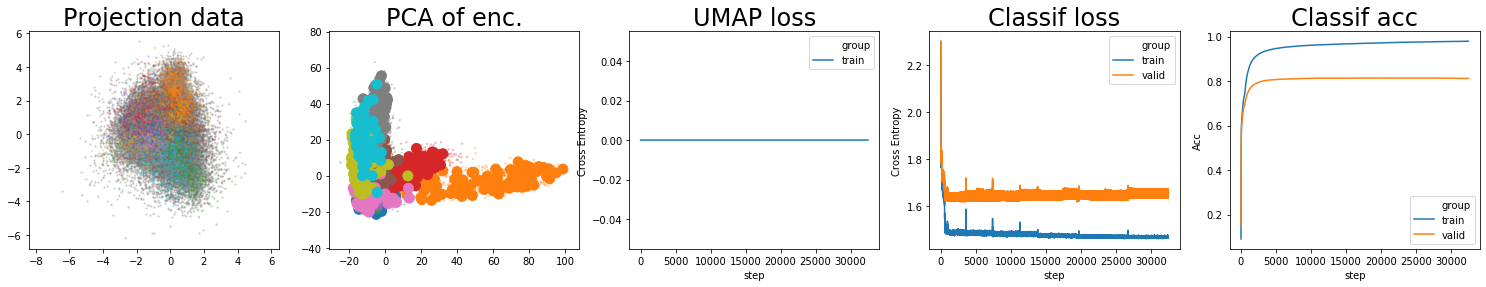

batch: 32500 | train acc: 0.9788 | val acc: 0.812
tf.Tensor(0.81200075, shape=(), dtype=float32) 0.8033320808410644


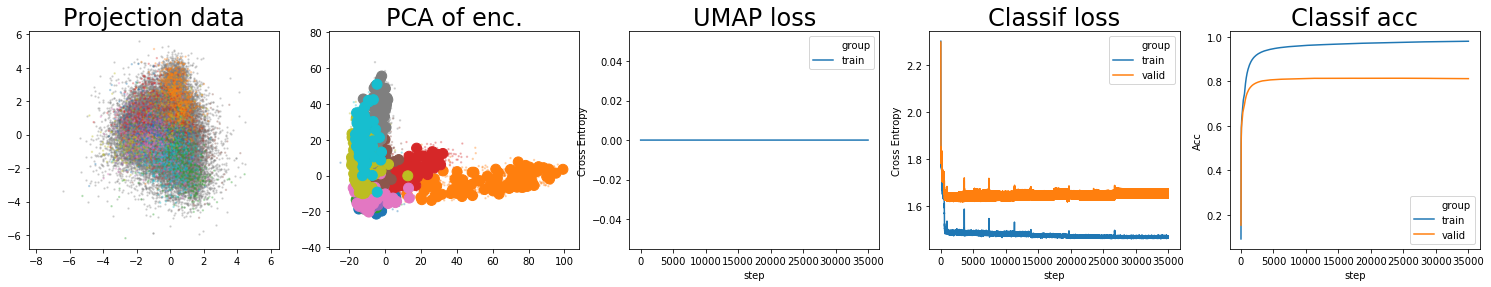

batch: 35000 | train acc: 0.9797 | val acc: 0.8116
tf.Tensor(0.81155914, shape=(), dtype=float32) 0.8033320808410644
Early stopping


In [29]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )
        
        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
        
        #### save network
        if batch % save_frequency == 0:
            print(val_acc , (best_saved_acc - max_reinitialize_delta))
            if val_acc > best_saved_acc:
                # save weights
                print('saving weights')
                model.encoder.save_weights((cpt_path / str(batch) / 'encoder').as_posix())
                model.embedder.save_weights((cpt_path / str(batch) / 'embedder').as_posix())
                model.classifier.save_weights((cpt_path / str(batch) / 'classifier').as_posix())
                best_saved_acc = val_acc.numpy()
                # save batch number
                best_saved_batch = copy.deepcopy(batch)
            
            elif val_acc < (best_saved_acc - max_reinitialize_delta):
                # reload weights
                print('reloading weights')
                model.encoder.load_weights((cpt_path / str(best_saved_batch) / 'encoder').as_posix())
                model.embedder.load_weights((cpt_path / str(best_saved_batch) / 'embedder').as_posix())
                model.classifier.load_weights((cpt_path / str(best_saved_batch) / 'classifier').as_posix())
                
                # reset batch
                batch = copy.deepcopy(best_saved_batch)
                # reset optimizer
                for var in model.optimizer.variables():
                    var.assign(tf.zeros_like(var))
                    
                # continue on with newly updated batch (past early stopping)
                continue
        
        #### early stopping
        # if there is an imporovement, set new best score
        if val_acc > best_acc + min_delta:
            last_improvement = 0
            best_acc = val_acc
        else:
            # if model has not improved and patience has been surpassed, quit
            if last_improvement>= patience:
                print('Early stopping')
                early_stopping = True
                break
            else:
                last_improvement+=1
            
        batch += 1
    if early_stopping:
        break

In [30]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

,wall_time,step,val,group,variable
0,1.595997e+09,1,0.091000,train,classif_acc
1,1.595997e+09,2,0.130500,train,classif_acc
2,1.595997e+09,3,0.149000,train,classif_acc
3,1.595997e+09,4,0.196750,train,classif_acc
4,1.595997e+09,5,0.236200,train,classif_acc
...,...,...,...,...,...
35712,1.595998e+09,35713,1.647191,valid,classif_loss
35713,1.595998e+09,35714,1.636647,valid,classif_loss
35714,1.595998e+09,35715,1.651356,valid,classif_loss
35715,1.595998e+09,35716,1.647595,valid,classif_loss


In [31]:
loss_df.to_pickle(cpt_path/'loss_df')

In [32]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

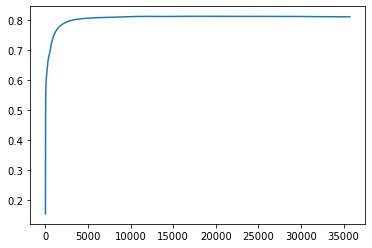

In [33]:
plt.plot(valid_acc)